<a href="https://colab.research.google.com/github/srilav/neuralnetwork/blob/main/stockpricemovement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [3]:
# API key H6KXC3V3N0S9UARZ
data_source = 'alphavantage' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = 'H6KXC3V3N0S9UARZ'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')

Data saved to : stock_market_data-AAL.csv


In [4]:
# Sort DataFrame by date
# the order of the data is crucial in time series modelling.
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Low,High,Close,Open
0,2005-09-27,19.1,21.4,19.3,21.05
1,2005-09-28,19.2,20.53,20.5,19.3
2,2005-09-29,20.1,20.58,20.21,20.4
3,2005-09-30,20.18,21.05,21.01,20.26
4,2005-10-03,20.9,21.75,21.5,20.9


In [5]:
df['Date'].loc[::500]

0       2005-09-27
500     2007-09-24
1000    2009-09-17
1500    2011-09-12
2000    2013-09-09
2500    2015-09-02
3000    2017-08-28
3500    2019-08-23
4000    2021-08-18
Name: Date, dtype: object

In [6]:
range(0,df.shape[0],500),df['Date'].loc[::500]

(range(0, 4127, 500), 0       2005-09-27
 500     2007-09-24
 1000    2009-09-17
 1500    2011-09-12
 2000    2013-09-09
 2500    2015-09-02
 3000    2017-08-28
 3500    2019-08-23
 4000    2021-08-18
 Name: Date, dtype: object)

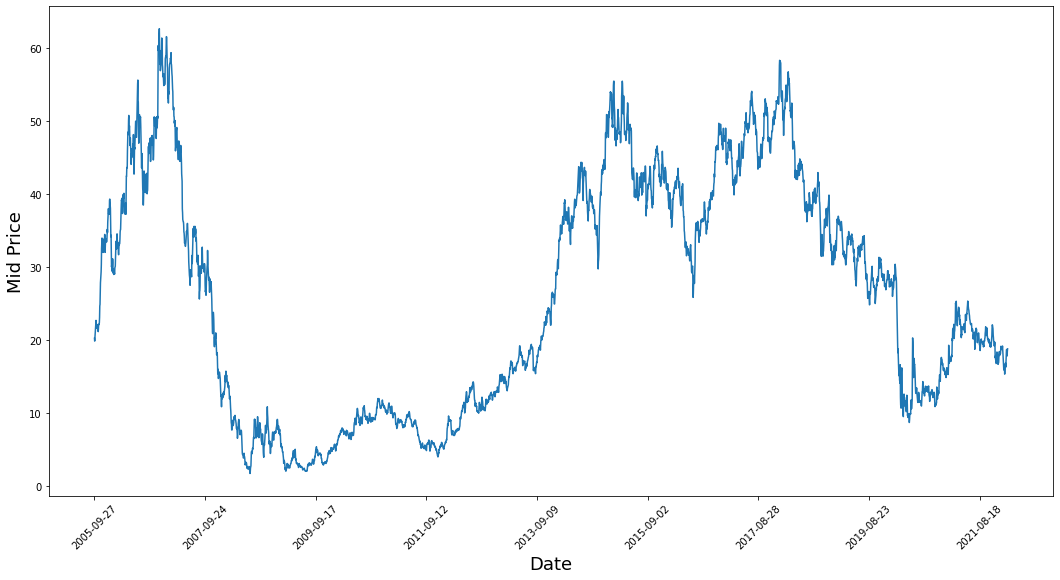

In [7]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [8]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High']
low_prices = df.loc[:,'Low']
mid_prices = (high_prices+low_prices)/2.0

In [13]:
mid_prices

0       0.303966
1       0.297643
2       0.305444
3        0.30996
4       0.321619
          ...   
4122    0.201573
4123    0.191359
4124    0.183674
4125    0.197489
4126    0.203388
Length: 4127, dtype: object

In [18]:
train_data = mid_prices[:2127].values
test_data = mid_prices[2127:].values

In [19]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [20]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 500
for di in range(0,2000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [21]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [24]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(2127):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [25]:
window_size = 500
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.02367


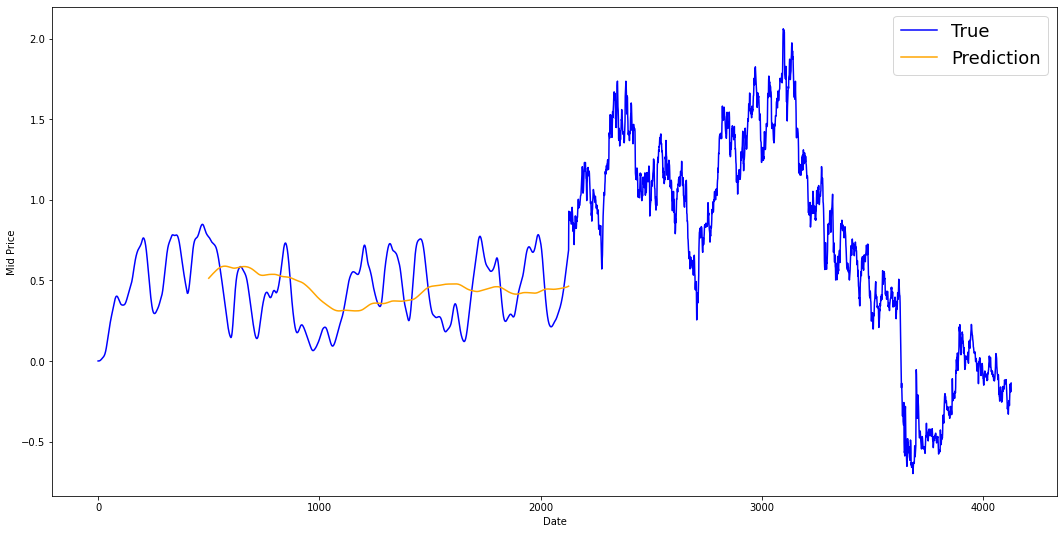

In [26]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [27]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00010


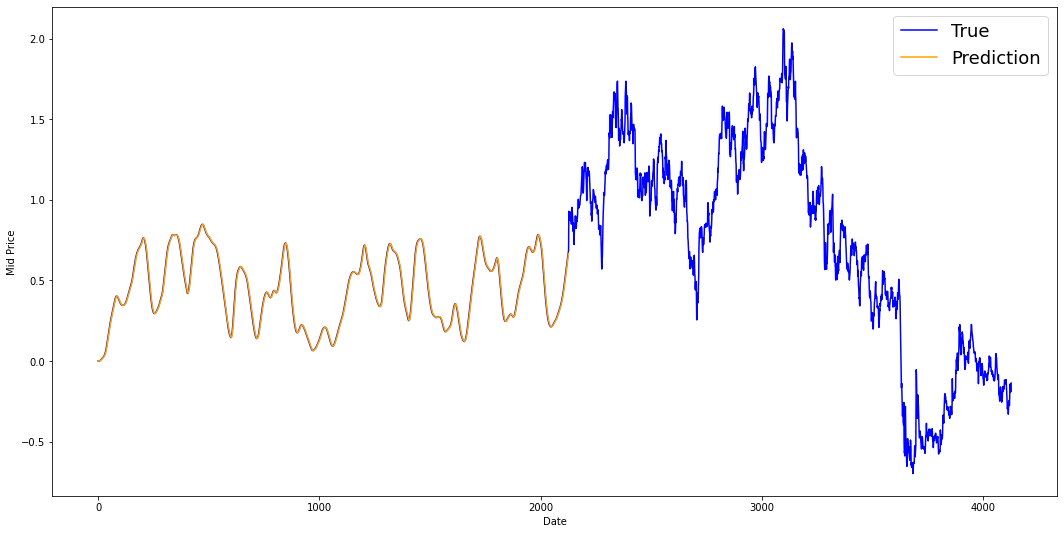

In [28]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [29]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [1.0772244e-05 6.3210654e-01 7.3045677e-01 3.3878973e-01 5.1835716e-01]

	Output: [1.0772244e-05 6.8480039e-01 7.2796202e-01 3.4035999e-01 5.4936129e-01]


Unrolled index 1
	Inputs:  [2.9085058e-05 6.4621711e-01 7.2796202e-01 3.3813801e-01 5.2867699e-01]

	Output: [2.6811633e-04 6.4621711e-01 7.2435915e-01 3.4293112e-01 5.4936129e-01]


Unrolled index 2
	Inputs:  [6.5643537e-05 6.5979636e-01 7.2435915e-01 3.3806035e-01 5.3901494e-01]

	Output: [6.5643537e-05 6.7270076e-01 7.1401638e-01 3.4035999e-01 5.7001412e-01]


Unrolled index 3
	Inputs:  [1.3539872e-04 6.7270076e-01 7.1969926e-01 3.3875465e-01 5.4936129e-01]

	Output: [5.0164695e-04 7.0621973e-01 7.0731831e-01 3.3875465e-01 5.5969638e-01]


Unrolled index 4
	Inputs:  [2.6811633e-04 6.8480039e-01 7.1401638e-01 3.4035999e-01 5.5969638e-01]

	Output: [5.0164695e-04 7.1542233e-01 6.8100631e-01 3.5158291e-01 5.7001412e-01]


In [31]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [37]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

#tf.reset_default_graph() # This is important in case you run this multiple times
tf.compat.v1.reset_default_graph()

In [47]:
# Input data.
train_inputs, train_outputs = [],[]
#tf.compat.v1.disable_eager_execution()
# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.compat.v1.placeholder(tf.compat.v1.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.compat.v1.placeholder(tf.compat.v1.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [68]:
lstm_cells = [
    tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.initializers.GlorotUniform ()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.compat.v1.nn.rnn_cell.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(drop_lstm_cells)
multi_cell =tf.compat.v1.nn.rnn_cell.MultiRNNCell(lstm_cells)
with tf.compat.v1.variable_scope("w", reuse=tf.compat.v1.AUTO_REUSE) as scope:
  w = tf.compat.v1.get_variable('w',shape=[num_nodes[-1], 1], initializer= tf.initializers.GlorotUniform ())
  b = tf.compat.v1.get_variable('b',initializer=tf.compat.v1.random_uniform([1],-0.1,0.1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  
